# **Projet d'Apprentissage Renforcé : Frozen Lake avec Q-Learning**

## Introduction
Ce projet utilise le Q-learning pour naviguer l'environnement 'Frozen Lake'. L'objectif est de former un agent capable de trouver le chemin optimal en évitant les pièges et obstacles. Ce projet inclut des cases spéciales comme les murs, power-ups et pièges, qui modifient les récompenses de l'agent.

## Importation des Bibliothèques
Cette section charge toutes les bibliothèques nécessaires pour le projet.

In [3]:
# Installer Gym pour l'environnement Frozen Lake
!!pip install gym

# Installer Matplotlib pour les visualisations de courbes
!pip install matplotlib


# (Optionnel) Installer Seaborn si vous souhaitez utiliser des cartes de chaleur pour visualiser la Q-table
!pip install seaborn


In [1]:
## Initialisation des Bibliothèques
import gym
import numpy as np
import pygame
import random
import warnings
import matplotlib.pyplot as plt
import sys

## Creation de l'environment de base

Dans cette section, nous allons présenter l'environnement de base Frozen Lake avant les modifications effectuées. L'environnement est initialisé avec la version par défaut de FrozenLake-v1, qui inclut une surface glissante (is_slippery=True), rendant les mouvements de l'agent moins prévisibles. Le paramètre render_mode='human' permet de visualiser la simulation en temps réel.

In [9]:
# Create the Frozen Lake environment
env = gym.make('FrozenLake-v1', render_mode='human', is_slippery=True) 

## Interaction avec l'environment

Le programme jouera 10 parties (épisodes) de Frozen Lake. Chaque itération correspond à un nouvel épisode et remet l'environnement à son état initial et reçoit l'état de départ (state).

Ensuite, il envoie l'action à l'environnement, qui retourne le nouvel état (next_state), la récompense obtenue (reward), et des indicateurs (terminated, truncated) indiquant si l'épisode est terminé.

La récompense est ajoutée à total_reward, et l'état est mis à jour. Fin d'épisode et affichage des résultats :

Affiche le score total de l'agent pour cet épisode.

In [13]:
# Number of episodes
num_episodes = 10

for episode in range(num_episodes):
    state, info = env.reset()  # Reset the environment for a new episode (note: `info` is now returned)
    done = False
    total_reward = 0
    
    while not done:
        env.render()  # Display the environment
        action = env.action_space.sample()  # Select a random action
        next_state, reward, terminated, truncated, info = env.step(action)  # Take action
        
        total_reward += reward  # Accumulate the reward
        state = next_state  # Update the state
        done = terminated or truncated  # Update the done flag

    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

# Close the environment after usage
env.close()

C:\Users\natha\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1 finished with total reward: 0.0
Episode 2 finished with total reward: 0.0
Episode 3 finished with total reward: 0.0
Episode 4 finished with total reward: 0.0
Episode 5 finished with total reward: 0.0
Episode 6 finished with total reward: 0.0
Episode 7 finished with total reward: 0.0
Episode 8 finished with total reward: 0.0
Episode 9 finished with total reward: 0.0
Episode 10 finished with total reward: 0.0


## Implémentation de l'Algorithme de Q-learning

## Étape 1 : Initialiser et visualiser l’environnement

Objectif : Créer et afficher un environnement personnalisé pour Frozen Lake, incluant des obstacles et des éléments spéciaux, et ajouter des fonctionnalités pour permettre la visualisation en temps réel de l’agent dans cet environnement.

In [2]:
# Initialisation de l'environnement Frozen Lake sans glissement
# L'environnement est une grille 4x4 avec des éléments spécifiques :
# - S : Point de départ
# - F : Surface glacée (case traversable sans danger)
# - H : Trous (fin de l'épisode si l'agent y tombe)
# - W : Murs (bloquent le passage)
# - P : Power-up (récompense bonus)
# - T : Piège (pénalité)
# - G : Objectif à atteindre pour gagner
env = gym.make("FrozenLake-v1", is_slippery=False)
env.reset()

# Définir les dimensions et couleurs harmonisées
WIDTH, HEIGHT = 400, 400
TILE_SIZE = WIDTH // 4
COLORS = {
    "S": (255, 182, 193),  # Départ (rose pâle)
    "F": (173, 216, 230),  # Surface glacée (bleu clair)
    "H": (25, 25, 112),    # Trou (bleu foncé)
    "G": (255, 223, 0),    # Objectif (jaune clair)
    "W": (100, 149, 237),  # Mur (bleu-gris)
    "P": (135, 206, 250),  # Power-up (turquoise clair)
    "T": (70, 130, 180)    # Piège (bleu acier)
}

# Nouvelle grille personnalisée avec la disposition mise à jour
custom_grid = np.array([
    ["S", "F", "W", "F"],
    ["F", "H", "F", "T"],
    ["F", "F", "H", "P"],
    ["H", "F", "F", "G"]
])

# Initialisation de Pygame et de la police, et chargement des images
pygame.init()
pygame.font.init()
font = pygame.font.Font(None, 36)
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Frozen Lake")

# Charger et ajuster les images
try:
    flag_img = pygame.image.load("flag.png").convert_alpha()
    robot_img = pygame.image.load("robot.png").convert_alpha()
    flag_img = pygame.transform.scale(flag_img, (TILE_SIZE, TILE_SIZE))
    robot_img = pygame.transform.scale(robot_img, (TILE_SIZE, TILE_SIZE))
except FileNotFoundError:
    print("Assurez-vous que les images 'flag.png' et 'robot.png' sont dans le dossier.")
    pygame.quit()
    exit()

# Fonction pour dessiner la grille et positionner l'agent
def draw_custom_grid(agent_pos=None):
    for i in range(4):
        for j in range(4):
            tile_type = custom_grid[i, j]
            color = COLORS.get(tile_type, (255, 255, 255))
            pygame.draw.rect(screen, color, (j * TILE_SIZE, i * TILE_SIZE, TILE_SIZE, TILE_SIZE))
            pygame.draw.rect(screen, (0, 0, 0), (j * TILE_SIZE, i * TILE_SIZE, TILE_SIZE, TILE_SIZE), 1)

            # Afficher le drapeau pour l'objectif
            if tile_type == "G":
                screen.blit(flag_img, (j * TILE_SIZE, i * TILE_SIZE))
            else:
                letter = font.render(tile_type, True, (0, 0, 0))
                screen.blit(letter, (j * TILE_SIZE + 10, i * TILE_SIZE + 10))

    # Positionner l'agent
    if agent_pos is not None:
        x, y = agent_pos % 4, agent_pos // 4
        screen.blit(robot_img, (x * TILE_SIZE, y * TILE_SIZE))

# Afficher la grille initialement
draw_custom_grid(agent_pos=0)
pygame.display.flip()
pygame.time.delay(2000)


2000

## Étape 2 : Boucle pour le déplacement aléatoire de l'agent

Pour tester l’affichage, créons une boucle simple où l’agent choisit une action aléatoire et se déplace dans la grille. Cela permet de voir l'agent se déplacer visuellement en temps réel.

In [3]:
# Boucle principale pour le déplacement aléatoire de l'agent sans connaissance a priori des murs
running = True
state = env.reset()  # Initialise l'état initial de l'environnement
max_moves = 20  # Limite le nombre de déplacements aléatoires de l'agent pour éviter des boucles infinies
moves = 0  # Compteur pour le nombre de déplacements effectués

while running and moves < max_moves:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Choisir une action aléatoire
    action = env.action_space.sample()  # L'agent choisit une action aléatoire

    # Effectuer le déplacement
    new_state, reward, done, truncated, _ = env.step(action)
    if isinstance(new_state, tuple):  # Pour gérer les cas où l'environnement retourne un tuple
        new_state = new_state[0]

    # Vérifier si la nouvelle position est un mur
    row, col = new_state // 4, new_state % 4  # Convertir l'état en coordonnées de grille
    if custom_grid[row, col] == "W":  # Si c'est un mur
        new_state = state  # Maintenir l'agent dans sa position actuelle si un mur bloque le chemin

    # Effacer l'écran et redessiner la grille avec la nouvelle position de l'agent
    screen.fill((0, 0, 0))
    draw_custom_grid(agent_pos=new_state)  # Fonction pour dessiner la grille et positionner l'agent
    pygame.display.flip()  # Met à jour l'affichage de la fenêtre
    pygame.time.delay(300)  # Pause pour observer le déplacement de l'agent

    # Met à jour l'état seulement si l'agent n'a pas été bloqué par un mur
    state = new_state
    moves += 1

    # Réinitialiser si l'agent atteint l'objectif ou tombe dans un piège
    if done or truncated:
        state = env.reset()
        moves = 0  # Réinitialise le compteur de déplacements pour un nouvel essai

pygame.quit()


C:\Users\natha\anaconda3\envs\test_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Étape 3: Entraînement de l’Agent
L'agent s'entraîne sur un nombre d'épisodes donné pour apprendre à naviguer dans l'environnement Frozen Lake. Des métriques comme les récompenses cumulatives et les taux de réussite sont suivies pour évaluer l'amélioration.

### Initialisation de la table Q et configuration des paramètres d'apprentissage

Dans cette étape, on va initialiser une table Q qui associe chaque état (position de l'agent) à une valeur pour chaque action possible (haut, bas, gauche, droite). Cette table sera mise à jour à chaque étape de l'apprentissage.
On va également configurer les paramètres essentiels pour Q-learning, y compris la stratégie d’exploration ε-greedy.
- Learning Rate (learning_rate) : Contrôle l'importance de chaque mise à jour (0.1 ici) et détermine à quel point les nouvelles informations (récompenses) influencent les valeurs de la table Q.
- Discount Factor (discount_factor) : Pondère les récompenses futures. Un facteur proche de 1 encourage l'agent à valoriser les récompenses futures.
- Exploration Rate (exploration_rate) :  Commence à 1 pour favoriser l'exploration au début et décroît au fil des épisodes pour que l'agent exploite ses connaissances vers la fin de l'apprentissage. Cela aide l'agent à explorer l'environnement au début et à se concentrer sur les actions optimales après avoir acquis une certaine expérience.

In [4]:
# Initialiser la table Q avec des zéros
# La table Q a une dimension (nombre d'états x nombre d'actions) pour stocker les valeurs de chaque action possible dans chaque état
qtable = np.zeros((env.observation_space.n, env.action_space.n))
# Afficher la table Q initiale
print("Table Q initiale avant l'apprentissage :")
print(qtable)

# Paramètres d'apprentissage
learning_rate = 0.1      # Alpha - Taux d'apprentissage (contrôle la vitesse d'ajustement des valeurs de la table Q)
discount_factor = 0.95   # Gamma - Facteur de discount (prend en compte les récompenses futures)
exploration_rate = 1.0   # Epsilon initial - Taux d'exploration (définit la probabilité d'explorer au début)
max_exploration_rate = 1.0   # Valeur maximale pour epsilon
min_exploration_rate = 0.01  # Valeur minimale pour epsilon
exploration_decay_rate = 0.001  # Taux de décroissance de l'exploration pour réduire epsilon au fil du temps
num_episodes = 5000           # Nombre d'épisodes d'apprentissage
max_steps_per_episode = 100    # Nombre maximum de pas par épisode

# Explication des choix des paramètres
# - learning_rate (alpha) est fixé à 0.1 pour que chaque mise à jour prenne en compte 10% de la nouvelle information.
# - discount_factor (gamma) est élevé (0.95) pour valoriser les récompenses futures, essentiel pour atteindre l'objectif.
# - exploration_rate (epsilon) commence à 1 pour que l'agent explore au maximum au début et diminue progressivement.

# Initialiser les listes pour enregistrer les pas par épisode et la valeur epsilon-greedy
steps_total = []
egreedy_total = []

Table Q initiale avant l'apprentissage :
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Boucle d’apprentissage Q-learning

**Objectif** : Exécuter plusieurs épisodes d’apprentissage pour que l’agent puisse explorer l’environnement, mettre à jour la table Q et apprendre la meilleure stratégie.

In [5]:
# Initialisation des listes pour suivre les performances: stocker les récompenses et le nombre de pas par épisode
rewards_total = []
steps_total = []
egreedy_total = []

# Boucle d'apprentissage Q-learning
for episode in range(num_episodes):
    # Réinitialisation de l'état au début de chaque épisode
    state = env.reset()
    if isinstance(state, tuple):  # Conversion de l'état en entier pour indexer la table Q
        state = state[0]
    done = False
    step_count = 0  # Initialiser le compteur de pas pour cet épisode
    episode_reward = 0  # Récompense cumulative pour cet épisode

    # Boucle interne pour chaque pas dans un épisode
    for step in range(max_steps_per_episode):
        # Stratégie epsilon-greedy pour choisir l'action
        if random.uniform(0, 1) < exploration_rate:
            action = env.action_space.sample()  # Action aléatoire
        else:
            action = np.argmax(qtable[state])  # Action optimale connue

        # Exécuter l'action et observer le nouvel état et la récompense
        new_state, reward, done, truncated, _ = env.step(action)
        if isinstance(new_state, tuple):
            new_state = new_state[0]

        # Ajustement des récompenses pour chaque type de case
        row, col = new_state // 4, new_state % 4  # Conversion de l'index de l'état en coordonnées de la grille
        cell_type = custom_grid[row, col]

        if cell_type == "G":   # Objectif atteint
            reward = 10  # Récompense suffisamment élevée pour un succès
        elif cell_type == "H": # Trou
            reward = -10
        elif cell_type == "P": # Power-up
            reward = 1.5
        elif cell_type == "T": # Piège
            reward = -1
        elif cell_type == "W": # Mur
            reward = -0.5  # Pas de déplacement si un mur est détecté
            new_state = state  # L'agent reste sur sa case actuelle

        # Mise à jour de la table Q (équation de Bellman)
        qtable[state, action] = qtable[state, action] + learning_rate * \
            (reward + discount_factor * np.max(qtable[new_state]) - qtable[state, action])

        # Transition vers le nouvel état
        state = new_state
        episode_reward += reward  # Accumuler la récompense
        step_count += 1  # Incrémenter le compteur de pas

        # Fin de l'épisode si l'agent atteint l'objectif ou tombe dans un trou
        if done:
            break

    # Enregistrer la récompense totale, le nombre de pas et la valeur epsilon-greedy pour cet épisode
    rewards_total.append(episode_reward)
    steps_total.append(step_count)
    egreedy_total.append(exploration_rate)

    # Décroissance de epsilon pour favoriser l'exploitation en fin d'apprentissage
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)


In [6]:
# Imprimer la table Q après l'apprentissage
print("Table Q après l'apprentissage :")
print(np.round(qtable, 2))
# Interprétation de la Table Q après l'apprentissage
# La table Q représente les valeurs d'action optimales pour chaque état.
# Chaque ligne correspond à un état de l'environnement, et chaque colonne représente une action :
# 0 = haut, 1 = droite, 2 = bas, 3 = gauche.
# 
# - Des valeurs Q élevées (proches de 10) indiquent des actions préférées par l'agent,
#   souvent celles qui mènent vers l'objectif ou des zones avantageuses.
# - Les valeurs négatives ou proches de zéro indiquent des actions que l'agent évite, 
#   comme celles menant à des trous (H) ou à des pièges (T).
# 
# Pour chaque état, l'agent choisira l'action avec la valeur Q la plus élevée pour maximiser
# sa récompense, en évitant les obstacles et en se dirigeant vers l'objectif.

Table Q après l'apprentissage :
[[  7.35   7.74   6.98   7.35]
 [  7.35  -9.25   5.17   6.57]
 [  0.     0.     0.     0.  ]
 [  2.68  -0.8    0.     0.15]
 [  7.74   8.15 -10.     7.35]
 [  0.     0.     0.     0.  ]
 [ -6.67  -3.98  -0.75  -1.01]
 [  0.     0.     0.     0.  ]
 [  8.15 -10.     8.57   7.74]
 [  8.15   9.02  -0.98 -10.  ]
 [  8.09   9.5    1.45  -0.69]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [-10.     9.02   9.5    8.57]
 [  9.02   9.5   10.    -0.98]
 [  0.     0.     0.     0.  ]]


In [8]:
#Afficher les statistiques de l'apprentissage
print("Percent of episodes finished successfully: {0:.2f}%".format(sum(rewards_total) / num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0:.2f}%".format(sum(rewards_total[-100:]) / 100))

print("Average number of steps: %.2f" % (sum(steps_total) / num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:]) / 100))

Percent of episodes finished successfully: 4.93%
Percent of episodes finished successfully (last 100 episodes): 9.60%
Average number of steps: 6.63
Average number of steps (last 100 episodes): 6.07


In [7]:
# Évaluation avec visualisation de la trajectoire pour observer le comportement de l'agent
num_tests = 10  # Réduire le nombre de tests pour observer les trajectoires
max_steps_per_episode = 100
success_count = 0

for episode in range(num_tests):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    success = False
    print(f"\nÉpisode {episode + 1} :")

    for step in range(max_steps_per_episode):
        # Choisir l'action optimale
        action = np.argmax(qtable[state])

        # Exécuter l'action et observer les résultats
        new_state, reward, done, truncated, _ = env.step(action)
        if isinstance(new_state, tuple):
            new_state = new_state[0]

        # Identifier le type de case et ajuster la récompense pour correspondre à `custom_grid`
        row, col = new_state // 4, new_state % 4
        cell_type = custom_grid[row, col]

        # Appliquer les récompenses personnalisées
        if cell_type == "G":   # Objectif atteint
            reward = 10
        elif cell_type == "H": # Trou
            reward = -10
        elif cell_type == "P": # Power-up
            reward = 1.5
        elif cell_type == "T": # Piège
            reward = -1
        elif cell_type == "W": # Mur
            reward = -0.5
            new_state = state  # L'agent reste sur sa case actuelle

        # Afficher la position et l'action de l'agent avec la récompense ajustée
        print(f"Étape {step + 1} : État {state}, Action {action}, Nouvel État {new_state}, Récompense {reward}")

        # Vérifier si l'agent atteint l'objectif
        if done and cell_type == "G":
            success = True
            print("Objectif atteint !")
            break
        elif done:
            print("Échec (trou ou obstacle rencontré)")
            break

        # Passer au nouvel état
        state = new_state

    # Compter les succès
    if success:
        success_count += 1



Épisode 1 :
Étape 1 : État 0, Action 1, Nouvel État 4, Récompense 0.0
Étape 2 : État 4, Action 1, Nouvel État 8, Récompense 0.0
Étape 3 : État 8, Action 2, Nouvel État 9, Récompense 0.0
Étape 4 : État 9, Action 1, Nouvel État 13, Récompense 0.0
Étape 5 : État 13, Action 2, Nouvel État 14, Récompense 0.0
Étape 6 : État 14, Action 2, Nouvel État 15, Récompense 10
Objectif atteint !

Épisode 2 :
Étape 1 : État 0, Action 1, Nouvel État 4, Récompense 0.0
Étape 2 : État 4, Action 1, Nouvel État 8, Récompense 0.0
Étape 3 : État 8, Action 2, Nouvel État 9, Récompense 0.0
Étape 4 : État 9, Action 1, Nouvel État 13, Récompense 0.0
Étape 5 : État 13, Action 2, Nouvel État 14, Récompense 0.0
Étape 6 : État 14, Action 2, Nouvel État 15, Récompense 10
Objectif atteint !

Épisode 3 :
Étape 1 : État 0, Action 1, Nouvel État 4, Récompense 0.0
Étape 2 : État 4, Action 1, Nouvel État 8, Récompense 0.0
Étape 3 : État 8, Action 2, Nouvel État 9, Récompense 0.0
Étape 4 : État 9, Action 1, Nouvel État 13, R

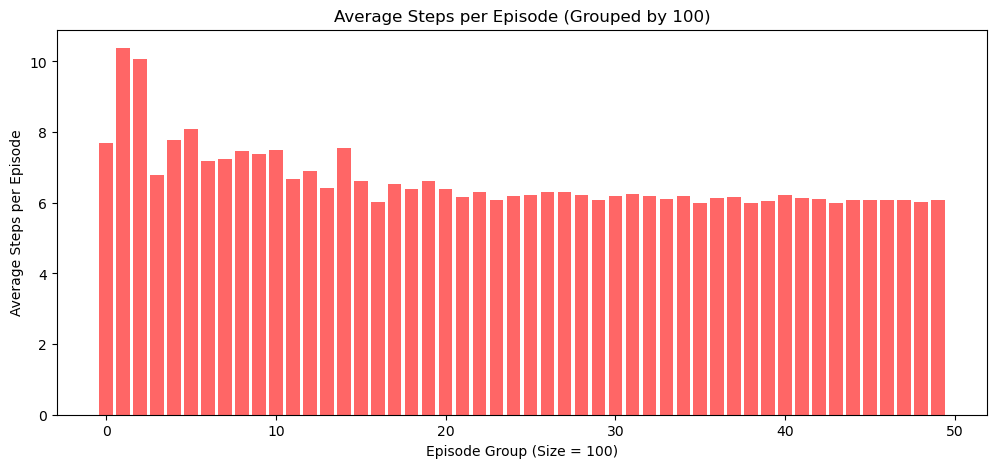

In [10]:
# Taille des groupes pour l'agrégation (ajustable)
window_size = 100

# Calculer la moyenne des étapes pour chaque groupe
avg_steps = [np.mean(steps_total[i:i + window_size]) for i in range(0, len(steps_total), window_size)]

# Création du graphique avec les données groupées
plt.figure(figsize=(12, 5))
plt.title("Average Steps per Episode (Grouped by 100)")
plt.bar(range(len(avg_steps)), avg_steps, alpha=0.6, color='red', width=0.8)
plt.xlabel("Episode Group (Size = 100)")
plt.ylabel("Average Steps per Episode")
plt.show()


Le graphique ci-dessus montre la moyenne des pas par épisode, regroupée par tranches de 100 épisodes. Cela permet de suivre l'évolution de l'efficacité de l'agent à travers le temps.

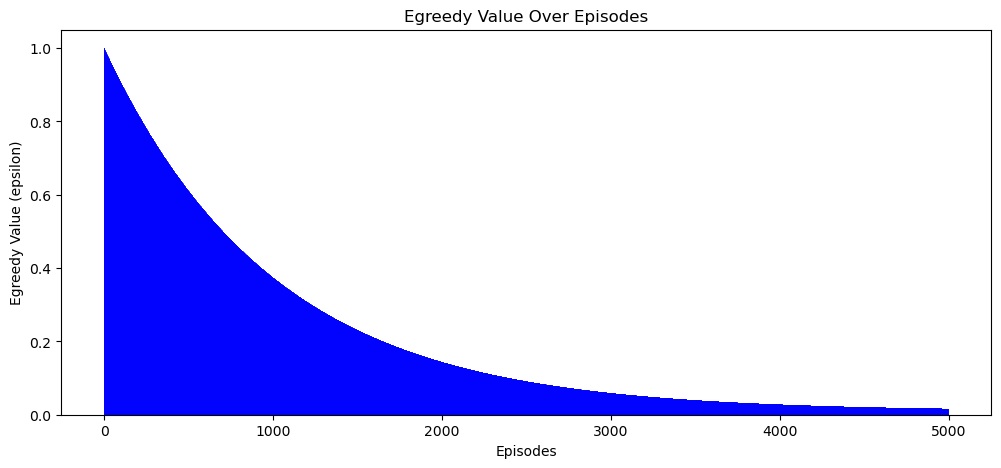

In [11]:
# Visualisation de la valeur epsilon-greedy par épisode
plt.figure(figsize=(12, 5))
plt.title("Egreedy Value Over Episodes")
plt.bar(range(len(egreedy_total)), egreedy_total, alpha=0.6, color='blue', width=5)
plt.xlabel("Episodes")
plt.ylabel("Egreedy Value (epsilon)")
plt.show()


Ce graphique illustre l'évolution de la valeur epsilon (taux d'exploration) au fil des épisodes. Il montre comment l'agent réduit progressivement l'exploration pour se concentrer sur l'exploitation de la meilleure stratégie apprise.

## Étape 4 : Évaluation de la Politique Apprise

In [13]:
# Évaluation de la politique apprise
total_success = 0
num_tests = 100  # Nombre d'épisodes de test
max_steps_per_episode = 100

for episode in range(num_tests):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False

    for step in range(max_steps_per_episode):
        # Choisir l'action optimale en suivant la table Q
        action = np.argmax(qtable[state])

        # Exécuter l'action et observer le résultat
        new_state, reward, done, truncated, _ = env.step(action)
        if isinstance(new_state, tuple):
            new_state = new_state[0]

        # Passer au nouvel état
        state = new_state

        # Vérifier si l'agent atteint l'objectif
        if done and reward == 1:  # Si l'objectif est atteint
            total_success += 1
            break
        elif done:  # Si l'agent tombe dans un trou
            break

# Calcul du taux de réussite
success_rate = total_success / num_tests * 100
print(f"Taux de réussite de la politique apprise : {success_rate}%")


Taux de réussite de la politique apprise : 100.0%


### Visualisation de la Politique Apprise

On va essayer d'observer le déplacement de l'agent en temps réel dans l'environnement en suivant la politique apprise (les actions optimales).

In [14]:
# Initialisation de Pygame
pygame.init()
screen = pygame.display.set_mode((400, 400))  # Ajustez la taille en fonction de vos besoins
pygame.display.set_caption("Visualisation de la politique apprise")

# Boucle de visualisation
state = env.reset()
if isinstance(state, tuple):
    state = state[0]
done = False

# Affichage de la grille et déplacement de l'agent
while not done:
    screen.fill((0, 0, 0))  # Remplir l'écran avec une couleur de fond

    # Afficher la grille et la position de l'agent
    draw_custom_grid(agent_pos=state)
    pygame.display.flip()
    pygame.time.delay(300)  # Pause pour observer le déplacement

    # Choisir l'action optimale en suivant la table Q
    action = np.argmax(qtable[state])

    # Exécuter l'action et observer le nouvel état
    new_state, reward, done, truncated, _ = env.step(action)
    if isinstance(new_state, tuple):
        new_state = new_state[0]

    # Mettre à jour la position de l'agent
    state = new_state

    # Fin de l'affichage si l'agent atteint l'objectif ou tombe dans un trou
    if done:
        draw_custom_grid(agent_pos=state)
        pygame.display.flip()
        pygame.time.delay(1000)
        break

# Quitter Pygame correctement après la visualisation
pygame.quit()


Ce code évalue la performance de l'agent en exécutant plusieurs essais après l'entraînement, en utilisant la table Q apprise. L'objectif est de mesurer la capacité de l'agent à atteindre l'objectif final sans tomber dans un trou, tout en évitant les obstacles. Les récompenses sont adaptées en fonction du type de case (objectif, trou, power-up, piège ou mur) pour refléter les règles personnalisées de l'environnement.

Pour chaque essai, l'agent commence dans l'état initial et prend des décisions en fonction de la stratégie optimale déterminée par la table Q. 
Le code enregistre le succès ou l'échec de chaque run et le nombre de pas effectués avant de terminer l'essai. À la fin des essais, deux graphiques sont générés :
- Un graphique des succès et échecs au cours des différents essais.
- Un graphique du nombre de pas nécessaires pour atteindre l'objectif dans les essais réussis.

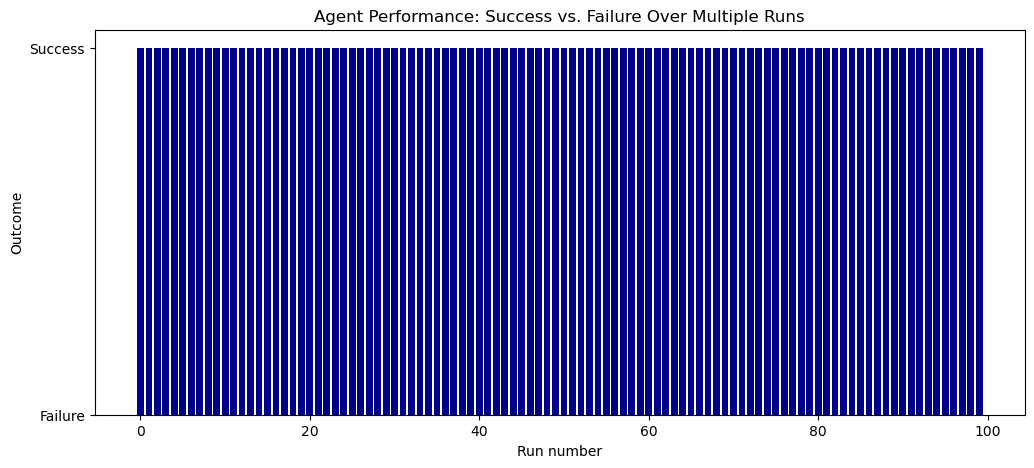

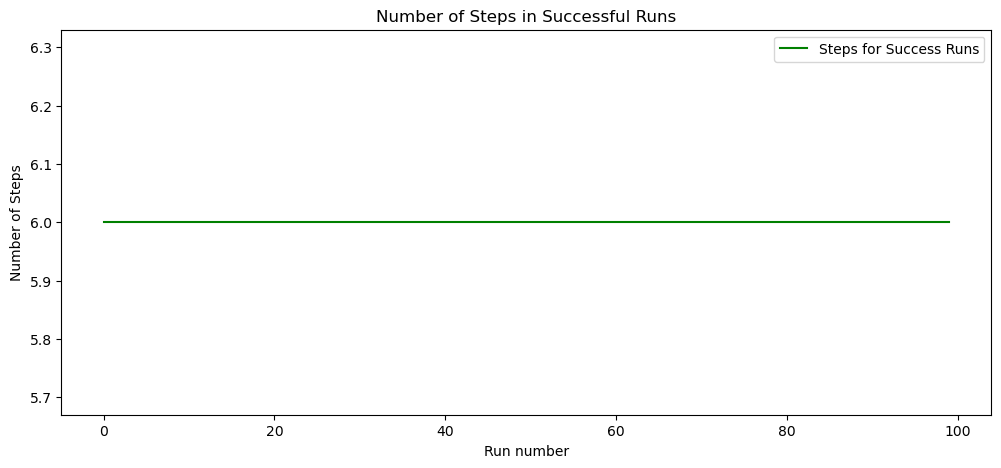

In [9]:
# Performance de l'Agent : Succès vs Échec au cours de plusieurs essais
num_tests = 100  # Nombre de runs pour évaluer la performance
max_steps_per_episode = 20  # Limite du nombre de pas par épisode
results = []
steps_taken = []

for _ in range(num_tests):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    success = False
    step_count = 0

    while not done and step_count < max_steps_per_episode:
        action = np.argmax(qtable[state])
        new_state, reward, done, truncated, _ = env.step(action)
        
        # Appliquer les récompenses personnalisées basées sur le type de case
        row, col = new_state // 4, new_state % 4  # Convertir l'état en coordonnées de grille
        cell_type = custom_grid[row, col]
        
        if cell_type == "G":   # Objectif atteint
            reward = 10
            success = True
        elif cell_type == "H": # Trou
            reward = -10
        elif cell_type == "P": # Power-up
            reward = 1.5
        elif cell_type == "T": # Piège
            reward = -1
        elif cell_type == "W": # Mur
            reward = -0.5
            new_state = state  # Bloque le mouvement si un mur est rencontré

        # Mise à jour de l'état si l'agent n'a pas rencontré un mur
        if cell_type != "W":
            state = new_state
        step_count += 1

        # Si l'agent atteint l'objectif, arrêter l'épisode
        if success:
            break

    results.append("Success" if success else "Failure")
    steps_taken.append(step_count)

# Convertir les résultats en données numériques pour le graphique
outcome_numeric = [1 if outcome == "Success" else 0 for outcome in results]

# Création du graphique de Succès/Échec
plt.figure(figsize=(12, 5))
plt.bar(range(num_tests), outcome_numeric, color=['darkblue'])
plt.yticks([0, 1], ["Failure", "Success"])
plt.xlabel("Run number")
plt.ylabel("Outcome")
plt.title("Agent Performance: Success vs. Failure Over Multiple Runs")

# Création du graphique des pas par run pour les succès uniquement
success_steps = [steps_taken[i] if results[i] == "Success" else None for i in range(num_tests)]
plt.figure(figsize=(12, 5))
plt.plot(range(num_tests), success_steps, 'g-', label="Steps for Success Runs")
plt.xlabel("Run number")
plt.ylabel("Number of Steps")
plt.title("Number of Steps in Successful Runs")
plt.legend()
plt.show()


Ce code vise à visualiser l'évolution des performances de l'agent au fil des épisodes en traçant une moyenne mobile du taux de succès. Après l'entraînement, chaque épisode est considéré comme un succès si l'agent atteint l'objectif (récompense > 0) et comme un échec sinon.

Pour lisser les fluctuations et observer une tendance plus claire, le taux de succès est calculé avec une moyenne mobile d'une fenêtre de taille prédéfinie (window_size = 1000). Cette moyenne mobile permet de visualiser la progression globale de l'agent, mettant en évidence les améliorations et les fluctuations de sa performance au fil du temps.

Le graphique final montre la tendance du taux de succès en fonction des épisodes, offrant ainsi une vue d'ensemble de l'apprentissage de l'agent tout au long de son entraînement.

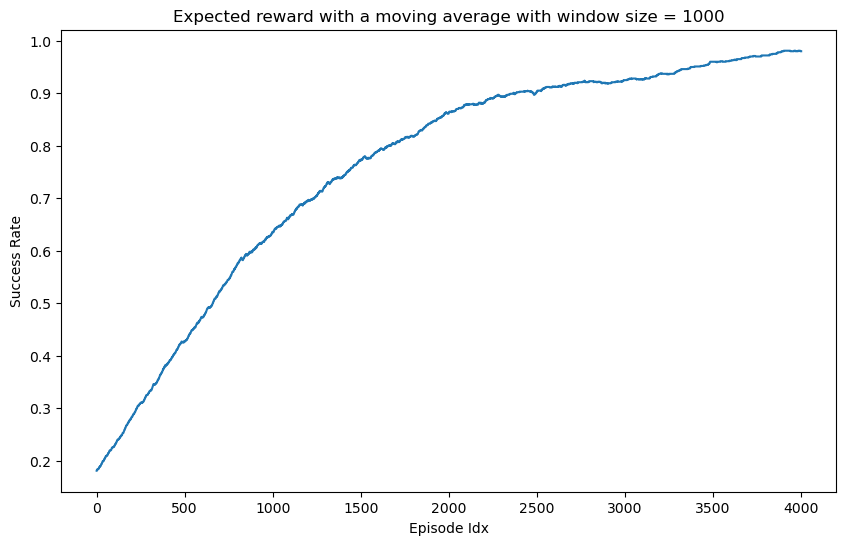

In [10]:
# Paramètres pour la moyenne mobile
window_size = 1000  # Taille de la fenêtre de la moyenne mobile

# Convertir les récompenses en taux de succès : succès (1) si récompense > 0, sinon échec (0)
success_rate = [1 if reward > 0 else 0 for reward in rewards_total]

# Calcul de la moyenne mobile du taux de succès
moving_average = np.convolve(success_rate, np.ones(window_size) / window_size, mode='valid')

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(moving_average)
plt.title(f"Expected reward with a moving average with window size = {window_size}")
plt.xlabel("Episode Idx")
plt.ylabel("Success Rate")
plt.show()
